# Image Classification of an American Sign Language Dataset

In this workshop, we will perform the data preparation, a CNN model creation, and the model's training steps using an image classification dataset: images of hands making letters in [American Sign Language](http://www.asl.gs/).

## Objectives

* Prepare image data for training
* Create and compile a CNN model for image classification
* Train a CNN model and observe its performance

## American Sign Language Dataset

The [American Sign Language alphabet](http://www.asl.gs/) contains 26 letters. Two of those letters (j and z) require movement, so they are not included in the training dataset.  

## Loading the Data

This dataset is not available via Keras (like MNIST is for example), so let's learn how to load custom data. By the end of this section we will have `x_train`, `y_train`, `x_valid`, and `y_valid` variables as before.

### Reading in the Data

The sign language dataset is in [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) (Comma Separated Values) format, the same data structure behind Microsoft Excel and Google Sheets. It is a grid of rows and columns with labels at the top, as seen in the [train](data/asl_data/sign_mnist_train.csv) and [valid](data/asl_data/sign_mnist_valid.csv) datasets (they may take a moment to load).

To load and work with the data, we'll be using a library called [Pandas](https://pandas.pydata.org/), which is a highly performant tool for loading and manipulating data. We'll read the CSV files into a format called a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [3]:
import pandas as pd

Pandas has a [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) method that expects a csv file, and returns a DataFrame:

In [4]:
train_df = pd.read_csv("asl_train.csv")
valid_df = pd.read_csv("asl_valid.csv")

### Exploring the Data

Let's take a look at our data. We can use the [head](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) method to print the first few rows of the DataFrame. Each row is an image which has a `label` column, and also, 784 values representing each pixel value in the image, just like with most of images datasets. Note that the labels currently are numerical values, not letters of the alphabet:

In [5]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Extracting the Labels

We would like to store our training and validation labels in `y_train` and `y_valid` variables. Here we create those variables and then delete the labels from our original dataframes, where they are no longer needed:

In [6]:
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

### Extracting the Images

We would like to store our training and validation images in `x_train` and `x_valid` variables. Here we create those variables:

In [7]:
x_train = train_df.values
x_valid = valid_df.values

### Summarizing the Training and Validation Data

We now have 27,455 images with 784 pixels each for training...

In [8]:
x_train.shape

(27455, 784)

...as well as their corresponding labels:

In [9]:
y_train.shape

(27455,)

For validation, we have 7,172 images...

In [10]:
x_valid.shape

(7172, 784)

...and their corresponding labels:

In [11]:
y_valid.shape

(7172,)

## Visualizing the Data

To visualize the images, we will again use the matplotlib library. We don't need to worry about the details of this visualization, but if interested, you can learn more about [matplotlib](https://matplotlib.org/) at a later time.

Note that we'll have to reshape the data from its current 1D shape of 784 pixels, to a 2D shape of 28x28 pixels to make sense of the image:

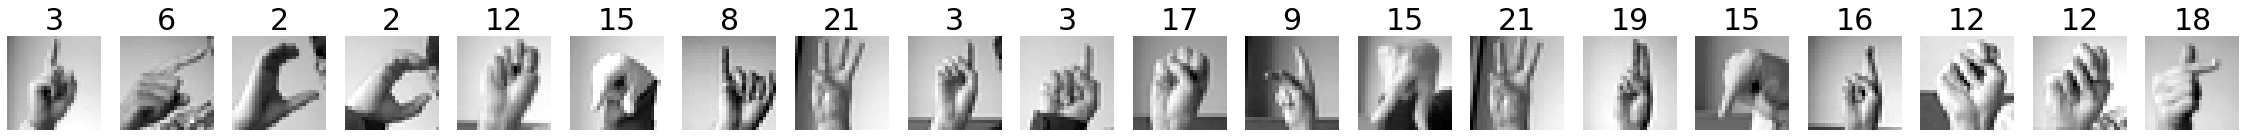

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))

num_images = 20
for i in range(num_images):
    row = x_train[i]
    label = y_train[i]
    
    image = row.reshape(28,28)
    plt.subplot(1, num_images, i+1)
    plt.title(label, fontdict={'fontsize': 30})
    plt.axis('off')
    plt.imshow(image, cmap='gray')

## Exercise: Normalize the Image Data

We are going to normalize the image data, meaning that their pixel values, instead of being between 0 and 255 as they are currently:

In [13]:
x_train.min()

0

In [14]:
x_train.max()

255

...should be floating point values between 0 and 1. Use the following cell to work. If you get stuck, look at the solution below.

In [ ]:
# TODO: Normalize x_train and x_valid.

### Solution

Click on the '...' below to show the solution.

In [15]:
# SOLUTION
# x_train = x_train / 255 is also correct)
x_train = train_df.values / 255
x_valid = valid_df.values / 255

## Exercise: Categorize the Labels

We are going to categorically encode the labels. Recall that we can use the [keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) method to accomplish this by passing it the values to encode, and, the number of categories to encode it into. Do your work in the cell below. We have imported `keras` and set the number of categories (24) for you.

In [16]:
import tensorflow.keras as keras
num_classes = 24

In [ ]:
# TODO: Categorically encode y_train and y_valid.

### Solution

Click on the '...' below to show the solution.

In [17]:
# SOLUTION
if not y_train.shape[-1] == 24:  # Avoid running multiple times
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

## Reshaping Images for a CNN

In this format, we don't have all the information about which pixels are near each other. Because of this, we can't apply convolutions that will detect features. Let's reshape our dataset so that they are in a 28x28 pixel format. This will allow our convolutions to associate groups of pixels and detect important features.

Note that for the first convolutional layer of our model, we need to have not only the height and width of the image, but also the number of [color channels](https://www.photoshopessentials.com/essentials/rgb/). Our images are grayscale, so we'll just have 1 channel.

That means that we need to convert the current shape `(27455, 784)` to `(27455, 28, 28, 1)`. As a convenience, we can pass the [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy.reshape) method a `-1` for any dimension we wish to remain the same, therefore:

In [23]:
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

In [24]:
x_train.shape, x_valid.shape

((27455, 28, 28, 1), (7172, 28, 28, 1))

## Exercise: Build a Convolutional Model


These days, many data scientists start their projects by borrowing model properties from a similar project. Assuming the problem is not totally unique, there's a great chance that people have created models that will perform well which are posted in online repositories like [TensorFlow Hub](https://www.tensorflow.org/hub) and the [NGC Catalog](https://ngc.nvidia.com/catalog/models). Today, we'll provide a model that will work well for this problem.

<img src="images/cnn.png" width=180 />

We covered many of the different kinds of layers in the lecture, and we will go over them all here with links to their documentation. When in doubt, read the official documentation (or ask [stackoverflow](https://stackoverflow.com/)).

### [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. Let's look at our first Conv2D layer:

In [ ]:
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same'...)

75 refers to the number of filters that will be learned. (3,3) refers to the size of those filters. Strides refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image.

### [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

In [ ]:
Like normalizing our inputs, batch normalization scales the values in the hidden layers to improve training. [Read more about it in detail here](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/). 

### [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

Max pooling takes an image and essentially shrinks it to a lower resolution. It does this to help the model be robust to translation (objects moving side to side), and also makes our model faster.

### [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

Dropout is a technique for preventing overfitting. Dropout randomly selects a subset of neurons and turns them off, so that they do not participate in forward or backward propagation in that particular pass. This helps to make sure that the network is robust and redundant, and does not rely on any one area to come up with answers.

### [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

We have seen dense layers before in our earlier models. Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

### Solution

Click on the '...' below to show the solution.

In [19]:
# SOLUTION
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

## Summarizing the Model

Run the cell below to summarize the model you just created:

This may feel like a lot of information, but don't worry. It's not critical that to understand everything right now in order to effectively train convolutional models. Most importantly we know that they can help with extracting useful information from images, and can be used in classification tasks.

Here, we summarize the model we just created. Notice how it has fewer trainable parameters than the model in the previous notebook:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

## Data Augmentation

Before compiling the model, it's time to set up our data augmentation.

Keras comes with an image augmentation class called `ImageDataGenerator`. We recommend checking out the [documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). It accepts a series of options for augmenting your data. Later in the course, we'll have you select a proper augmentation strategy. For now, take a look at the options we've selected below, and then execute the cell to create an instance of the class:

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

## Batch Size
Another benefit of the `ImageDataGenerator` is that it [batches](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/) our data so that our model can train on a random sample.

If the model is [truly random](http://sites.utexas.edu/sos/random/), meaning that the data is properly shuffled so it's fair like a deck of cards, then our sample can do a good job of representing all of our data even though it is a tiny fraction of the population. For each step of the training, the model will be dealt a new batch.

In practice, a batch size of 32 and 64 does well. Run the cell below to see what kind of batches we'll be training our model with. Is our randomizer fairly randomizing? Are all of the images recognizable ASL letters?

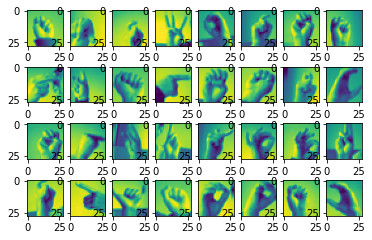

In [69]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## Fitting the Data to the Generator

Next, the generator must be fit on the training dataset.

In [71]:
datagen.fit(x_train)

## Compiling the Model

We'll [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#compile) our model with the same options as before, using [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) to reflect the fact that we want to fit into one of many categories, and measuring the accuracy of our model:

In [21]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## Exercise: Train the Model

Use the model's `fit` method to train it for 5 epochs using the training and validation images and labels created above:

In [ ]:
# TODO: Train the model for 5 epochs.

### Solution

Click on the '...' below to show the solution.

In [28]:
import tensorflow
tensorflow.config.run_functions_eagerly(True)

In [73]:
# SOLUTION
model.fit(img_iter,
          epochs=10,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/10
857/857 [==============================] - 129s 150ms/step - loss: 1.2040 - accuracy: 0.7609 - val_loss: 0.0880 - val_accuracy: 0.9700
Epoch 2/10
857/857 [==============================] - 128s 149ms/step - loss: 0.3367 - accuracy: 0.8930 - val_loss: 0.0751 - val_accuracy: 0.9780
Epoch 3/10
857/857 [==============================] - 128s 150ms/step - loss: 0.2221 - accuracy: 0.9305 - val_loss: 0.1407 - val_accuracy: 0.9589
Epoch 4/10
857/857 [==============================] - 128s 149ms/step - loss: 0.1769 - accuracy: 0.9445 - val_loss: 0.0612 - val_accuracy: 0.9776
Epoch 5/10
857/857 [==============================] - 125s 145ms/step - loss: 0.1485 - accuracy: 0.9541 - val_loss: 0.4009 - val_accuracy: 0.8783
Epoch 6/10
857/857 [==============================] - 130s 151ms/step - loss: 0.1299 - accuracy: 0.9608 - val_loss: 0.0751 - val_accuracy: 0.9782
Epoch 7/10
857/857 [==============================] - 128s 149ms/step - loss: 0.1176 - accuracy: 0.9630 - val_loss: 0.0440 -

## Discussion: What happened?

We can see that the training accuracy got to a fairly high level, but the validation accuracy was not as high. What happened here?

Think about it for a bit before clicking on the '...' below to reveal the answer.

`# SOLUTION`
This is an example of the model learning to categorize the training data, but performing poorly against new data that it has not been trained on. Essentially, it is memorizing the dataset, but not gaining a robust and general understanding of the problem. This is a common issue called *overfitting*. We will discuss overfitting in the next two lectures, as well as some ways to address it.

## Preparing the Image for Prediction

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

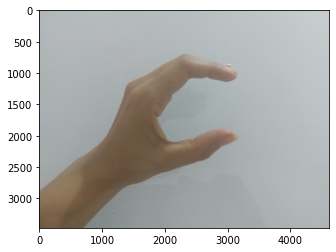

In [63]:
show_image('asl_c.jpg')

In [74]:
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_image(image_path):
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(28,28))
    return image

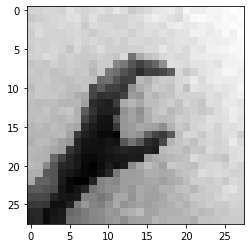

In [64]:
image = load_and_scale_image('asl_c.jpg')
plt.imshow(image, cmap='gray')

In [45]:
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"

Let's put everything in a function so that we can make predictions just from the image file. Implement it in the function below using the functions and steps above. If you need help, you can reveal the solution by clicking the three dots below.

In [46]:
def predict_letter(file_path):
    # Show image
    FIXME
    # Load and scale image
    image = FIXME
    # Convert to array
    image = FIXME
    # Reshape image
    image = FIXME
    # Normalize image
    image = FIXME
    # Make prediction
    prediction = FIXME
    # Convert prediction to letter
    predicted_letter = FIXME
    # Return prediction
    return predicted_letter  

## Solution

Click on the '...' below to view the solution.

In [65]:
# SOLUTION
import numpy as np
def predict_letter(file_path):
    # Show image
    show_image(file_path)
    # Convert to array
    image = load_and_scale_image(file_path)
    image = image_utils.img_to_array(image)
    # Reshape imagel
    image = image.reshape(1,28,28,1)
    # Normalize image
    image = image/255
    # Make prediction
    prediction = model.predict(image)
    # convert prediction to letter
    predicted_letter = alphabet[np.argmax(prediction)]
    return predicted_letter

1/1 [==============================] - 0s 23ms/step


'g'

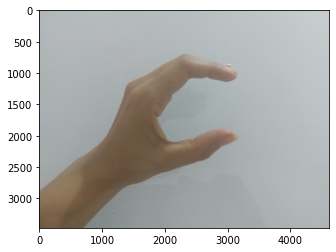

In [79]:
predict_letter("asl_c.jpg")

## Summary

In this section you built your own neural network to perform image classification that is quite accurate. Congrats!

At this point we should be getting somewhat familiar with the process of loading data (incuding labels), preparing it, creating a model, and then training the model with prepared data.